A deeper dive into the grants flagged as being to do with tech grants

- where do the tech grants sit in the reduced landscape?
- what are the most and least techy clusters (most and least proportion of tech grants in cluster) and where are they?
- what are the thematic areas?
- what are the biggest grants and clusters in terms of amount awarded?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import bokeh.plotting as bpl
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.models import BoxZoomTool, WheelZoomTool, HoverTool, Label
from bokeh.palettes import d3
from bokeh.io import output_file, reset_output, save, export_png
from bokeh.resources import CDN
from bokeh.embed import file_html

bpl.output_notebook()

Loading BokehJS ...

In [3]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from nutrition_labels.cluster_tech_grants import load_cluster, get_cluster_keys

## Load clusters and grant data

In [6]:
datestamp = '201125'
cluster_grant_data = pd.read_csv(f'data/processed/cluster_grant_data_{datestamp}.csv')
cluster = load_cluster(f'models/clustering/grants_clusters_{datestamp}.pkl')
tech_cluster = load_cluster(f'models/clustering/tech_grants_clusters_{datestamp}.pkl')

In [7]:
cluster_kws, cluster_centroids, cluster_numbers = get_cluster_keys(cluster)
tech_cluster_kws, tech_cluster_centroids, tech_cluster_numbers = get_cluster_keys(tech_cluster)

In [8]:
tech_cluster_grant_data = cluster_grant_data.loc[cluster_grant_data['Tech grant?']]

In [9]:
tech_props = []
for cluster_num in range(0, np.max(cluster.cluster_ids)+1):
    num_tech = sum([t==cluster_num for t in tech_cluster_grant_data['Cluster number'].tolist()])
    num_all = sum([t==cluster_num for t in cluster_grant_data['Cluster number'].tolist()])
    tech_props.append(num_tech/num_all if num_all!=0 else 0)

In [10]:
top_n = 10
most_tech_clusters = list(np.argsort(tech_props)[-top_n:])
most_tech_clusters.reverse()
least_tech_clusters = np.argsort(tech_props)[:top_n]

most_least_col = []
for c in cluster_grant_data['Cluster number'].tolist():
    if c in most_tech_clusters:
        most_least_col.append(1)
    elif c in least_tech_clusters:
        most_least_col.append(0)
    else:
        most_least_col.append(2)
cluster_grant_data['Techy cluster'] = most_least_col

## Plotting functions

In [11]:
# convert colours to hex to fit to bokeh
def convert_hex(rgb_colour_list):
    return ["#%02x%02x%02x" % (int(r*255), int(g*255), int(b*255)) for r, g, b in rgb_colour_list]

def cluster_plot(cluster, grant_data, colour_by='cluster', alpha=0.1, label_font_size=10,
                 cluster_kws=None, cluster_centroids=None, save_html=False, datestamp=None):
    
    titles = grant_data['Title'].tolist()
    texts = [g[0:300] for g in grant_data['Grant Text'].tolist()]
    grant_ids = grant_data['Internal ID'].tolist()
    
    x = [v[0] for v in cluster.reduced_points]
    y = [v[1] for v in cluster.reduced_points]
    
    if colour_by=='cluster':
        clust_num = cluster.cluster_ids
        colour_by_name = "Cluster number"
        colors = [(0.8,0.8,0.8)] + [(r,g,b) for r,g,b,a in cm.gist_rainbow(np.linspace(0, 1, np.max(clust_num)+2))]
        color_clust = [(colors[c+1]) for c in clust_num]
    elif colour_by=='tech_cluster':
        clust_num = cluster.cluster_ids
        colour_by_name = "Tech cluster number"
        colors = [(0.8,0.8,0.8)] + [(r,g,b) for r,g,b,a in cm.gist_rainbow(np.linspace(0, 1, np.max(clust_num)+2))]
        color_clust = [(colors[c+1]) for c in clust_num]
    elif colour_by=='tech_or_not':
        clust_num = grant_data['Tech grant?'].tolist()
        colour_by_name = "Tech grant?"
        colors = [(0.8,0.8,0.8), (0,0,1)]
        color_clust = [(colors[c]) for c in clust_num]
    elif colour_by=='techy grant':
        clust_num = grant_data['Techy cluster'].tolist()
        techy_clust_nums = grant_data.loc[grant_data['Techy cluster']!=2]["Cluster number"].unique()
        colour_by_name = "Most (1) or least (0) techy cluster"
        colors = [(0.95,0.05,0.05), (0.05,0.05,0.95), (0.9,0.9,0.9)]
        color_clust = [(colors[c]) for c in clust_num]

    source = ColumnDataSource(data=dict(
        x=x, y=y, title=titles, texts=texts, cluster_col=convert_hex(color_clust), cluster=clust_num, grant_id = grant_ids
    ))
    hover = HoverTool(tooltips=[
        ("Grant ID", "@grant_id"),
        ("Text", "@texts"),
        (colour_by_name, "@cluster"),
    ])

    p = figure(plot_width=800, plot_height=800, tools=[hover, WheelZoomTool(), BoxZoomTool()],
               title="Grants", toolbar_location="below")
    
    p.circle('x', 'y', color='cluster_col', alpha=alpha, size=5, source=source)
    if cluster_kws:
        if colour_by=='techy grant':
            cluster_kws = {k:v for k,v in cluster_kws.items() if k in techy_clust_nums}    
            cluster_centroids = {k:v for k,v in cluster_centroids.items() if k in techy_clust_nums}
        for cluster_num, cluster_kw in cluster_kws.items():
            citation = Label(x=cluster_centroids[cluster_num][0], y=cluster_centroids[cluster_num][1],
                     text=cluster_kw, render_mode='css',
                     background_fill_color='white', background_fill_alpha=0.6, text_font_size=f'{label_font_size}px')
            p.add_layout(citation)
            
    if save_html:
        file_name = f'{colour_by}_{len(colors)}_{datestamp}'
        output_file(f'{file_name}.html')
        save(p)
    else:
        show(p)

In [12]:
def get_kw_n(cluster_kws, n):
    return {c_num: ','.join(kws.split(',')[0:n]) for c_num, kws in cluster_kws.items()}

## Visualise clusters
- How many in each?
- What proportion of tech grants in each?
- Plot clusters in all grant space
- Plot tech grants in all grant space
- Plot most and least techy grants in all grant space
- Plot tech clusters in tech grant space
- Keywords in highest and lowest techy grants
- Keywords in tech grants

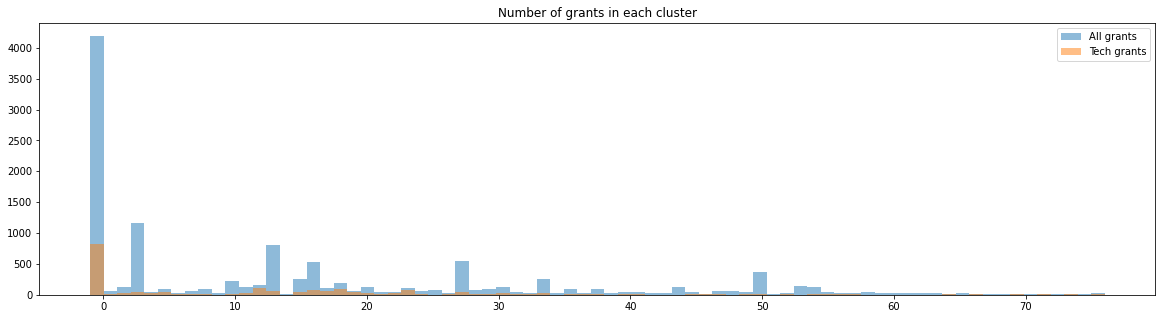

In [13]:
bins = np.linspace(-1, np.max(cluster.cluster_ids), np.max(cluster.cluster_ids))
plt.figure(figsize=(20,5))
a_hist = plt.hist(cluster_grant_data['Cluster number'].tolist(), bins, alpha=0.5, label='All grants')
t_hist = plt.hist(tech_cluster_grant_data['Cluster number'].tolist(), bins, alpha=0.5, label='Tech grants')
plt.legend(loc='upper right')
plt.title('Number of grants in each cluster')
plt.show()

In [35]:
np.max(cluster.cluster_ids)

76

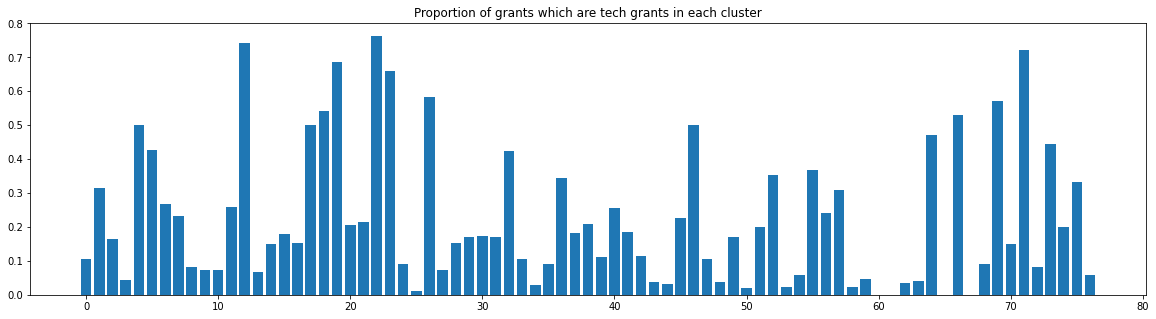

In [14]:
plt.figure(figsize=(20,5))
plt.bar(range(0, np.max(cluster.cluster_ids)+1), tech_props)
plt.title('Proportion of grants which are tech grants in each cluster')
plt.show()

## Cluster plots outputted with labels

In [15]:
cluster_plot(cluster, cluster_grant_data, cluster_kws=get_kw_n(cluster_kws,2), cluster_centroids=cluster_centroids, label_font_size=14, save_html=True, datestamp=datestamp)

In [16]:
cluster_plot(cluster, cluster_grant_data,  colour_by = 'tech_or_not', cluster_kws=get_kw_n(cluster_kws,2), cluster_centroids=cluster_centroids, label_font_size=14, alpha=0.2, save_html=True, datestamp=datestamp)

INFO:bokeh.io.state:Session output file 'tech_or_not_2_201125.html' already exists, will be overwritten.


In [17]:
cluster_plot(cluster, cluster_grant_data,  colour_by = 'techy grant', cluster_kws=get_kw_n(cluster_kws,3), cluster_centroids=cluster_centroids, label_font_size=14, alpha=0.2, save_html=True, datestamp=datestamp)

INFO:bokeh.io.state:Session output file 'techy grant_3_201125.html' already exists, will be overwritten.


In [18]:
cluster_plot(tech_cluster, tech_cluster_grant_data,  colour_by = 'tech_cluster', cluster_kws=get_kw_n(tech_cluster_kws,3), cluster_centroids=tech_cluster_centroids, label_font_size=14, alpha=0.7, save_html=True, datestamp=datestamp)

## Cluster plots outputted without labels

In [31]:
cluster_plot(cluster, cluster_grant_data, save_html=True, datestamp='_nolabs_'+datestamp)

In [32]:
cluster_plot(cluster, cluster_grant_data,  colour_by = 'tech_or_not', alpha=0.2, save_html=True, datestamp='_nolabs_'+datestamp)

In [33]:
cluster_plot(cluster, cluster_grant_data,  colour_by = 'techy grant', alpha=0.2, save_html=True, datestamp='_nolabs_'+datestamp)

In [34]:
cluster_plot(tech_cluster, tech_cluster_grant_data,  colour_by = 'tech_cluster', alpha=0.7, save_html=True, datestamp='_nolabs_'+datestamp)

In [19]:
cluster_tech_info=[]
for cluster_num in list(set(cluster.cluster_ids)):
    cluster_idx = [i for i, c_num in enumerate(cluster.cluster_ids) if c_num==cluster_num]
    cluster_tech_numbers = len(cluster_grant_data.iloc[cluster_idx].loc[cluster_grant_data['Tech grant?']])
    cluster_prop_tech = cluster_tech_numbers/cluster_numbers[cluster_num]
    cluster_tech_info.append(
        {
            'Cluster number': cluster_num,
            'Keywords':cluster_kws[cluster_num],
            'Number grants':cluster_numbers[cluster_num],
            'Number tech grants':cluster_tech_numbers,
            'Proportion tech grants': cluster_prop_tech
        }
    )
cluster_tech_info = pd.DataFrame(cluster_tech_info).sort_values('Proportion tech grants', ascending=False)

In [36]:
cluster_tech_info.head(5)

,Cluster number,Keywords,Number grants,Number tech grants,Proportion tech grants
22,22,"twin,datum,000,resource,sample,linkage,cohort,...",38,29,0.763158
12,12,"genetic,variant,genome,association,genotype,da...",152,113,0.743421
71,71,"adhd,delirium,cognitive,disorder,neurodevelopm...",18,13,0.722222
19,19,"datum,resource,database,software,access,analys...",64,44,0.687500
23,23,"brain,epilepsy,seizure,mri,neuroimaging,model,...",109,72,0.660550


In [37]:
cluster_tech_info.tail(5)

,Cluster number,Keywords,Number grants,Number tech grants,Proportion tech grants
25,25,"text,medical,manuscript,medieval,galen,edition...",82,1,0.012195
65,65,"autophagy,cell,protein,cgmp,cftr,pathway,signa...",33,0,0.000000
67,67,"vsg,trypanosome,nuclear,expression,brucei,prot...",18,0,0.000000
61,61,"notch,foxg1,cell,signal,fate,neuron,progenitor...",33,0,0.000000
60,60,"enhancer,promoter,gene,element,regulatory,tran...",29,0,0.000000


In [38]:
max(tech_cluster.cluster_ids)

44

In [22]:
tech_cluster_info = []
for cluster_num in list(set(tech_cluster.cluster_ids)):
    tech_cluster_info.append(
        {
            'Cluster number': cluster_num,
            'Keywords':tech_cluster_kws[cluster_num],
            'Number grants':tech_cluster_numbers[cluster_num]
        }
    )
tech_cluster_info = pd.DataFrame(tech_cluster_info).sort_values('Number grants', ascending=False)

In [23]:
tech_cluster_info.head(10)

,Cluster number,Keywords,Number grants
4,4,"gene,variant,disease,cell,study,genome,identif...",314
45,-1,"patient,health,research,disease,study,datum,ri...",296
3,3,"health,intervention,care,mental,policy,service...",214
2,2,"brain,model,image,stroke,functional,patient,ne...",209
0,0,"research,support,fund,health,wellcome,engageme...",188
1,1,"disease,vaccine,infection,virus,outbreak,trans...",114
7,7,"tb,treatment,tuberculosis,drug,patient,hiv,res...",59
5,5,"cvd,risk,blood,pressure,bp,cardiovascular,hype...",43
12,12,"hiv,art,infection,africa,intervention,treatmen...",39
14,14,"cancer,tumour,breast,patient,treatment,screen,...",39


### Money spent per cluster

In [24]:
cluster_grant_data['Amount Awarded float'] = [float(m.replace(',', '')) for m in cluster_grant_data['Amount Awarded']]

In [25]:
# Check that it's all in the same until
cluster_grant_data['Currency'].unique()

array(['GBP'], dtype=object)

In [26]:
money_per_cluster = cluster_grant_data.groupby(['Tech cluster number'])['Amount Awarded float'].agg('mean')
money_per_cluster = pd.Series.to_frame(money_per_cluster)
money_per_cluster['Tech cluster number'] = list(money_per_cluster.index)
money_per_cluster['Keywords'] = [tech_cluster_kws[i] for i in list(money_per_cluster.index)]
money_per_cluster.index = money_per_cluster['Keywords']
money_per_cluster.sort_values('Amount Awarded float', ascending=False, inplace=True)

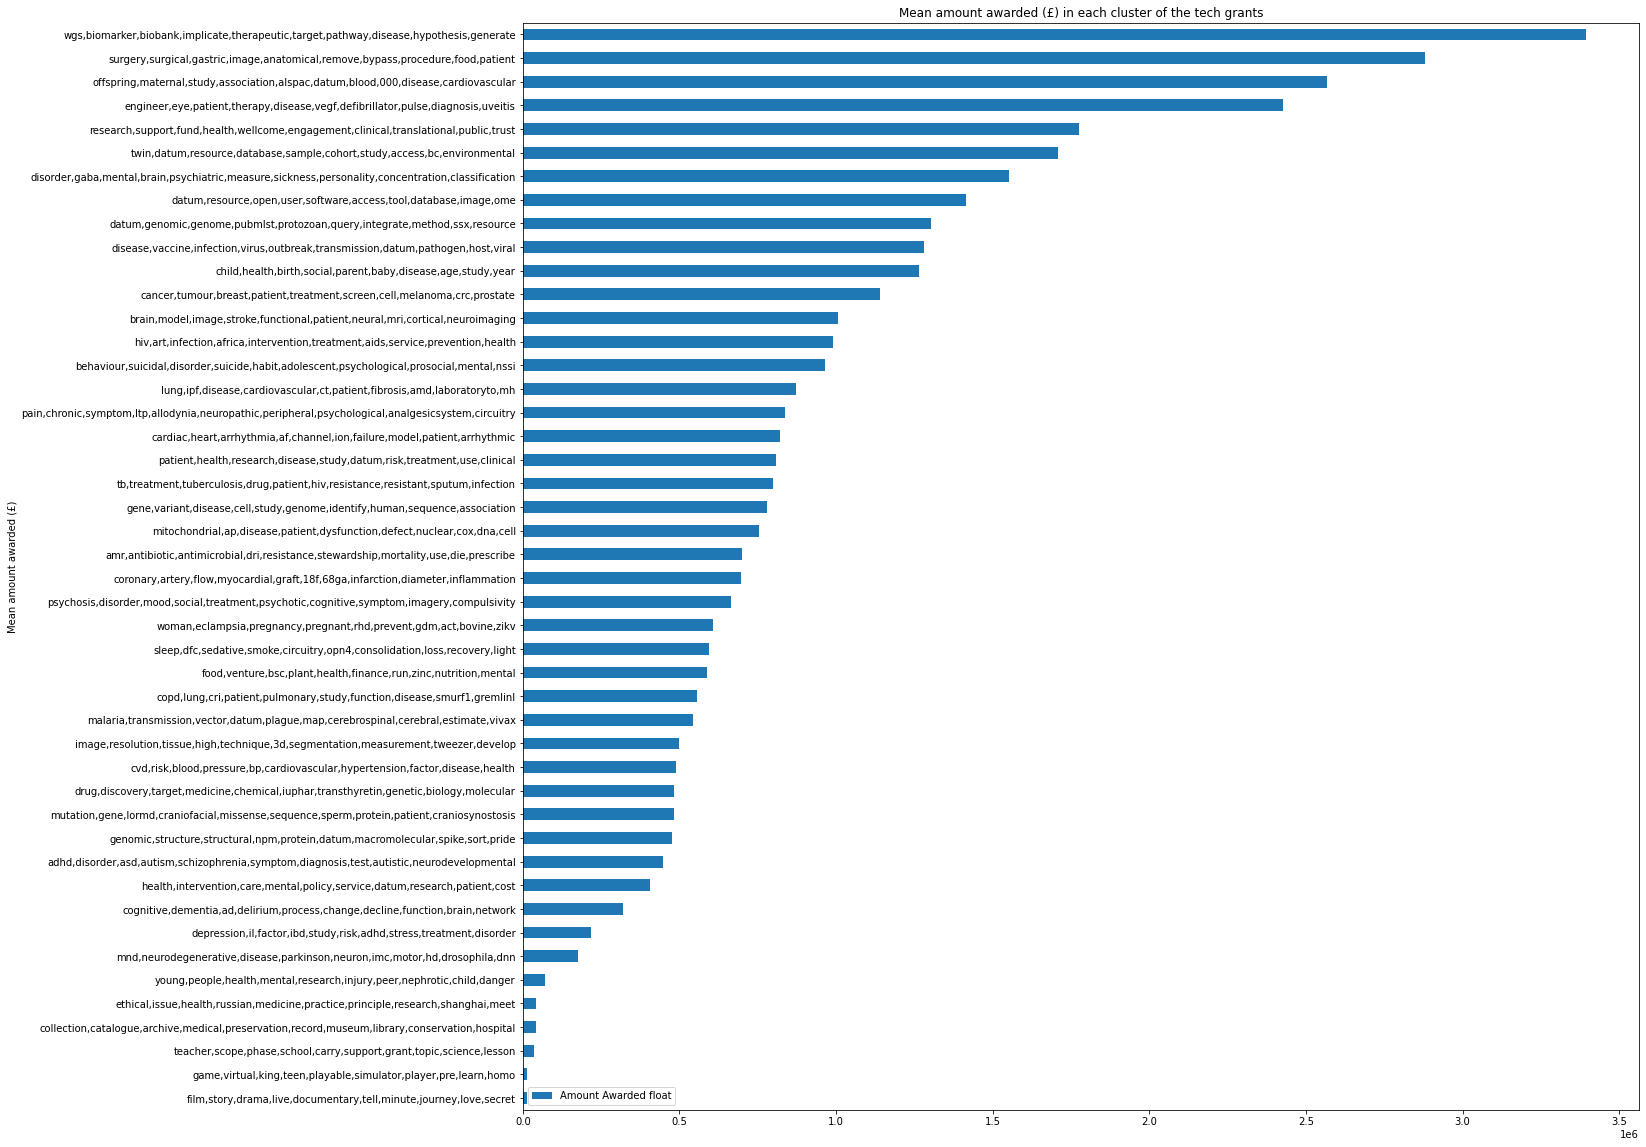

In [27]:
ax = money_per_cluster.iloc[::-1].plot.barh(y='Amount Awarded float', rot=0, figsize=(20,20))
plt.title('Mean amount awarded (£) in each cluster of the tech grants')
plt.ylabel('Mean amount awarded (£)')
plt.show()

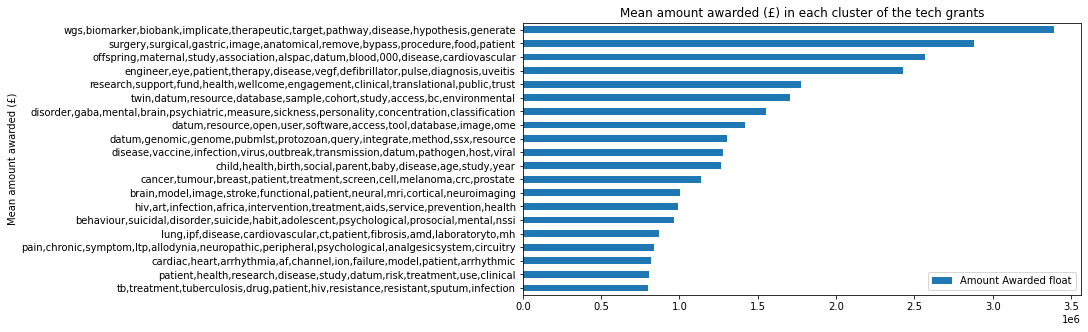

In [28]:
ax = money_per_cluster[0:20].iloc[::-1].plot.barh(y='Amount Awarded float', rot=0, figsize=(10,5))
plt.title('Mean amount awarded (£) in each cluster of the tech grants')
plt.ylabel('Mean amount awarded (£)')
plt.show()

## Biggest grants

In [39]:
len(cluster_grant_data)

11996

In [29]:
cluster_grant_data_sorted = cluster_grant_data.sort_values('Amount Awarded float', ascending=False)

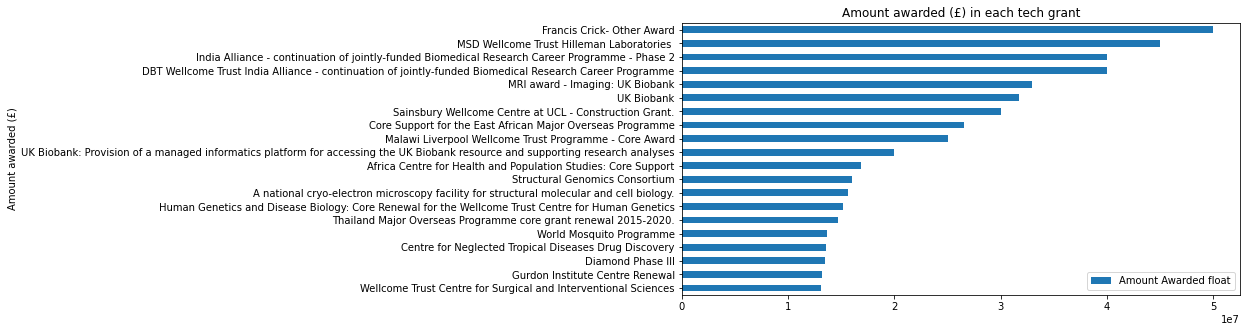

In [30]:
ax = cluster_grant_data_sorted[0:20].iloc[::-1].plot.barh(x='Title',y='Amount Awarded float', rot=0, figsize=(10,5))
plt.title('Amount awarded (£) in each tech grant')
plt.ylabel('Amount awarded (£)')
plt.show()